# Weather forecast
This work is part of a use case of the [UFCity](#UFCity) solution.

This document handles and analyzes data from the datasets present in the [CityPulse](http://iot.ee.surrey.ac.uk:8080/datasets.html#weather) project.
This work aims to develop a model, via machine learning, to predict the time series trend.

The data from the climate were collected by pressure, humidity, temperature, wind direction, and speed sensors. Given the new data entered into the system, the idea is to identify the possible values for these variables.

In [ ]:
pip install pmdarima

In [27]:
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# searching the best pdq via GridSearchCV
from sklearn.model_selection import GridSearchCV
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read file
df_hum          = pd.read_csv("../datasets/weather-data/hum.csv");
df_tempm        = pd.read_csv("../datasets/weather-data/tempm.csv");
df_wspdm        = pd.read_csv("../datasets/weather-data/wspdm.csv");
df_wdird        = pd.read_csv("../datasets/weather-data/wdird.csv");
df_pressurem    = pd.read_csv("../datasets/weather-data/pressurem.csv");
df_dewptm       = pd.read_csv("../datasets/weather-data/dewptm.csv");

# list of df
df_list = [df_hum, df_tempm, df_wspdm, df_wdird, df_pressurem, df_dewptm]

In [3]:
df_tempm.shape, df_hum.shape, df_wspdm.shape, df_wdird.shape, df_pressurem.shape, df_dewptm.shape

((4356, 2), (4356, 2), (4356, 2), (4356, 2), (4356, 2), (4356, 2))

In [4]:
# naming the columns
for _df in df_list:
    _df.columns = ['timestamp', 'value']

In [5]:
# data clening: removing '"', ';', and blankspaces.
for _df in df_list:
    _df['timestamp'] = _df['timestamp'].replace(['"', ';'], '', regex=True)
    _df['value'] = _df['value'].replace(['"', ';'], '', regex=True)
    
    # convert series
    _df['timestamp'] = pd.to_datetime(_df['timestamp'])
    _df['value'] = pd.to_numeric(_df['value'], errors='coerce').round(1)

In [6]:
# merge dfs
def merge_dataframes(df1, df2):
    return pd.merge(df1, df2, on='timestamp')

df_merged = reduce(merge_dataframes, df_list)

In [7]:
df_merged.columns = ['timestamp', 'hum', 'tempm', 'wspdm', 'wdird', 'pressurem', 'dewptm']

In [8]:
df_merged.sort_values('timestamp')

,timestamp,hum,tempm,wspdm,wdird,pressurem,dewptm
32,2014-08-01 00:00:00,56.0,18.0,7.4,220.0,1012.0,11.0
11,2014-08-01 00:20:00,68.0,18.0,7.4,210.0,1012.0,12.0
64,2014-08-01 00:50:00,68.0,18.0,5.6,210.0,1012.0,12.0
1,2014-08-01 01:20:00,73.0,18.0,7.4,210.0,1012.0,13.0
27,2014-08-01 01:50:00,73.0,19.0,7.4,210.0,1012.0,14.0
...,...,...,...,...,...,...,...
4346,2014-09-30 22:20:00,77.0,14.0,14.8,110.0,1026.0,10.0
4293,2014-09-30 22:50:00,77.0,14.0,14.8,120.0,1026.0,10.0
4307,2014-09-30 23:00:00,70.0,14.0,14.8,120.0,1026.0,10.0
4323,2014-09-30 23:20:00,77.0,14.0,14.8,120.0,1026.0,10.0


In [9]:
# set index
df_merged.set_index('timestamp', inplace=True)

In [10]:
df_merged.sort_index(inplace=True)
df_merged = df_merged.asfreq('20T')

In [11]:
# using interpolate to fill missing data
for col in df_merged.columns:
    df_merged[col] = df_merged[col].fillna(df_merged[col].interpolate())

In [12]:
has_nan = df_merged.isnull().any().any()

if has_nan:
    print("There are NaN values in the DataFrame")
else:
    print("There are no NaN values in the DataFrame")

There are no NaN values in the DataFrame


In [13]:
df_copy = df_merged.copy()

In [14]:
df_merged#[df_merged['wdird'] < 1]

,hum,tempm,wspdm,wdird,pressurem,dewptm
timestamp,,,,,,
2014-08-01 00:00:00,56.000000,18.0,7.4,220.0,1012.0,11.000000
2014-08-01 00:20:00,68.000000,18.0,7.4,210.0,1012.0,12.000000
2014-08-01 00:40:00,69.666667,18.0,7.4,210.0,1012.0,12.333333
2014-08-01 01:00:00,71.333333,18.0,7.4,210.0,1012.0,12.666667
2014-08-01 01:20:00,73.000000,18.0,7.4,210.0,1012.0,13.000000
...,...,...,...,...,...,...
2014-09-30 22:20:00,77.000000,14.0,14.8,110.0,1026.0,10.000000
2014-09-30 22:40:00,73.500000,14.0,14.8,115.0,1026.0,10.000000
2014-09-30 23:00:00,70.000000,14.0,14.8,120.0,1026.0,10.000000


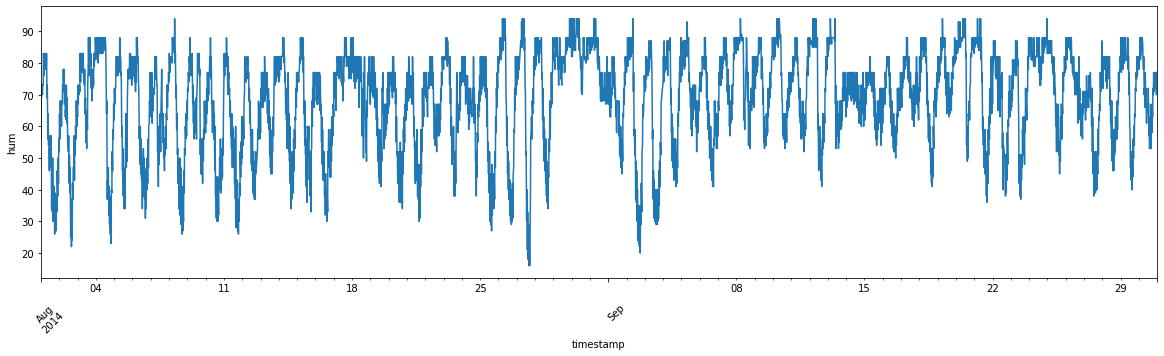

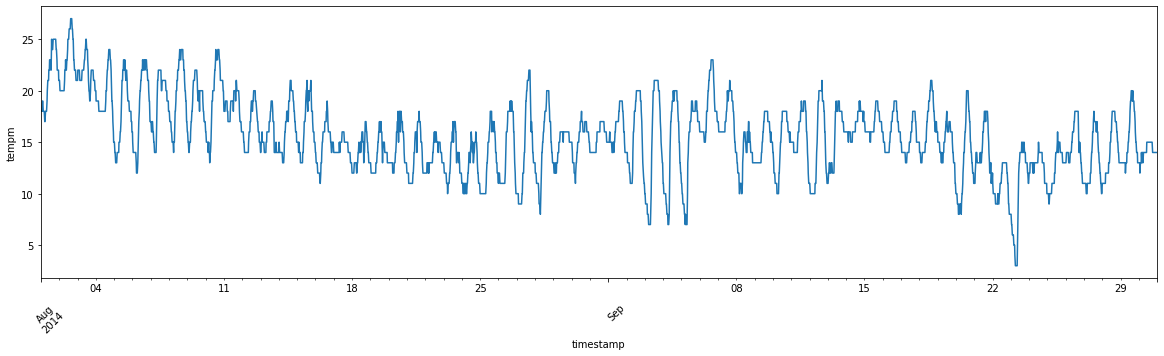

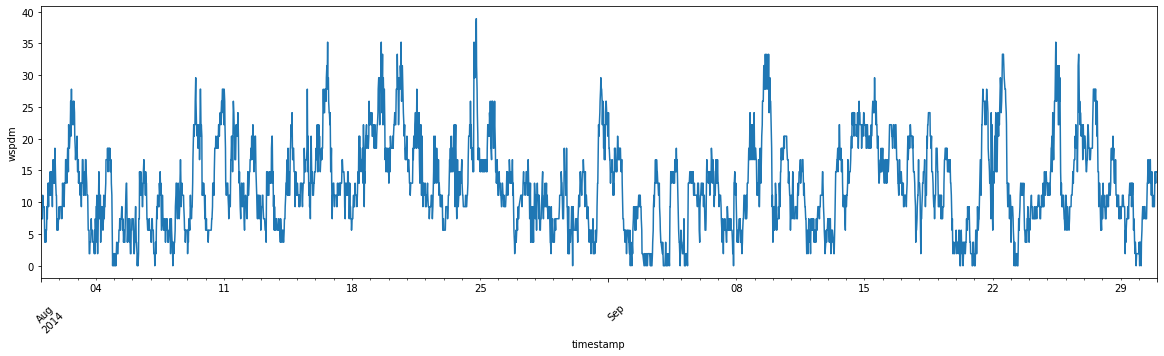

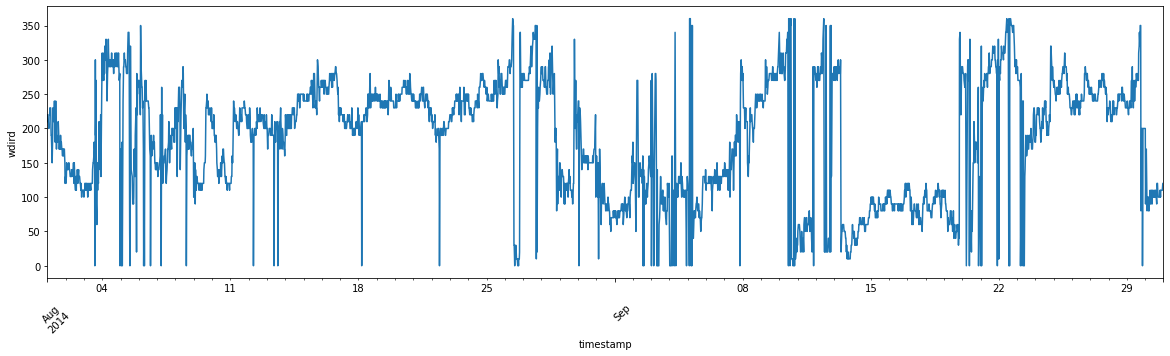

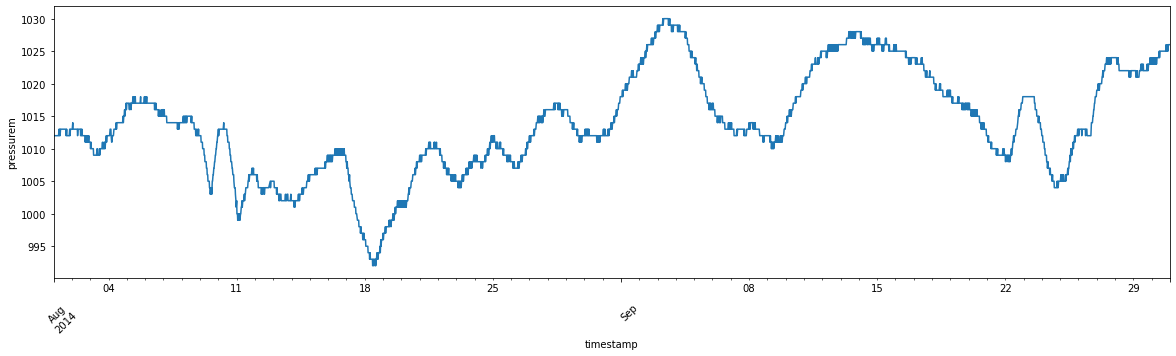

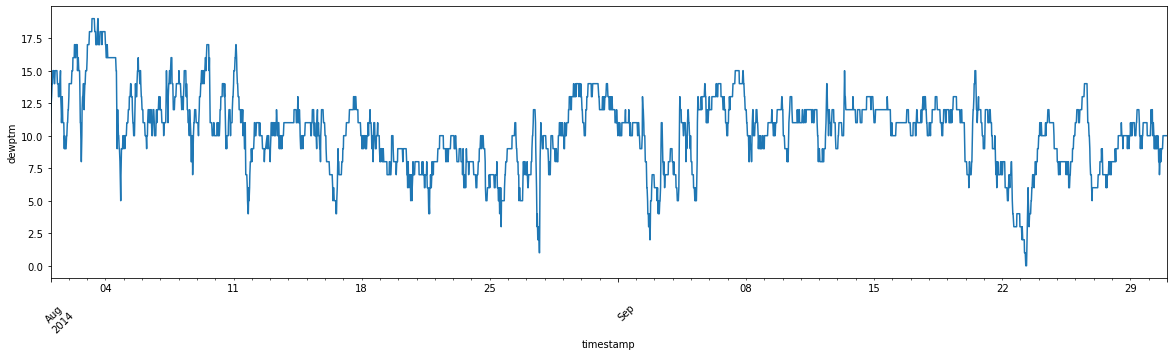

In [15]:
for i in range(0,6):
    plt.figure(figsize=(20, 5))
    df_merged.iloc[:, i].plot()
    plt.xticks(rotation=45)
    plt.xlabel('timestamp')
    plt.ylabel(df_merged.columns[i])
    plt.show()


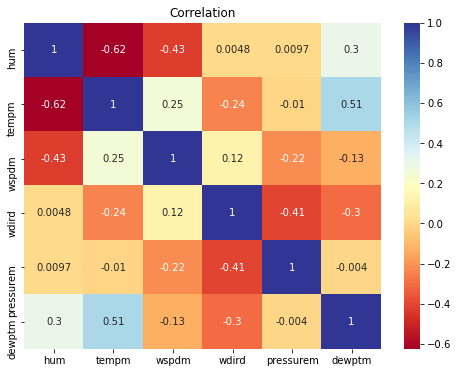

In [16]:
# Verify correlation
correlation_matrix = df_merged.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation')
plt.show()

After analyzing the variables, we found that there is no clear and direct correlation between them. Therefore, we can rule out multivariate analysis and focus on individual time series analysis.

### Separating training and testing data

In [22]:
# 90% train and 10% test
df_train = df_merged[:3953]
df_test = df_merged[3953:]

In [23]:
df_merged.shape, df_train.shape, df_test.shape

((4392, 6), (3953, 6), (439, 6))

### Searching for the best model for ARIMA

In [37]:
# def commum
def predictions(best_model_fit, num_period):
    # Fazer previsões
    predictions = best_model_fit.predict(start=len(df_train), end=len(df_train) + num_period - 1)

    # Exibir as previsões
#     print("Previsões:")
#     print(predictions)
#     print("\n")
    df_predictions = pd.DataFrame(predictions)
    return df_predictions

In [79]:
# Testing

def testing_plt(col, model_fit):
    df_predictions = predictions(model_fit, len(df_test))
    
    # Plotar as séries temporais
    plt.plot(df_predictions.index, df_predictions['predicted_mean'], label='predictions')
    plt.plot(df_test[col].index, df_test[col], label='test')

    # Adicionar rótulos e título ao gráfico
    plt.xlabel('Tempo')
    plt.ylabel(col)
    plt.title('Gráfico de Linhas')

    # Adicionar legenda
    plt.legend()

    # Exibir o gráfico
    plt.show()

#### Using AutoARIMA

In [25]:
# searching the best pdq via AutoARIMA
for col in df_merged.columns:
    print(col, pm.auto_arima(df_train[col], seasonal=True))

hum  ARIMA(5,1,2)(0,0,0)[0]          
tempm  ARIMA(1,1,3)(0,0,0)[0]          
wspdm  ARIMA(0,1,2)(0,0,0)[0]          
wdird  ARIMA(4,1,4)(0,0,0)[0] intercept
pressurem  ARIMA(4,1,5)(0,0,0)[0]          
dewptm  ARIMA(2,1,2)(0,0,0)[0] intercept


In [30]:
auto_model_hum = ARIMA(df_train['hum'], order=(5,1,2))
auto_model_hum_fit = auto_model_hum.fit()

auto_model_tempm = ARIMA(df_train['tempm'], order=(1,1,3))
auto_model_tempm_fit = auto_model_tempm.fit()

auto_model_wspdm = ARIMA(df_train['wspdm'], order=(0,1,2))
auto_model_wspdm_fit = auto_model_wspdm.fit()

auto_model_wdird = ARIMA(df_train['wdird'], order=(4,1,4))
auto_model_wdird_fit = auto_model_wdird.fit()

auto_model_pressurem = ARIMA(df_train['pressurem'], order=(4,1,5))
auto_model_pressurem_fit = auto_model_pressurem.fit()

auto_model_dewptm = ARIMA(df_train['dewptm'], order=(2,1,2))
auto_model_dewptm_fit = auto_model_dewptm.fit()

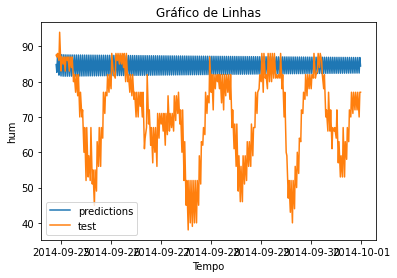

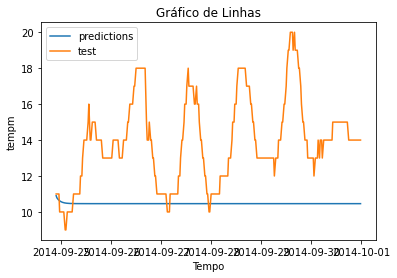

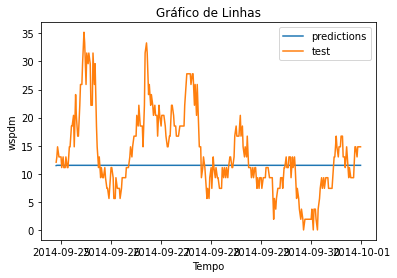

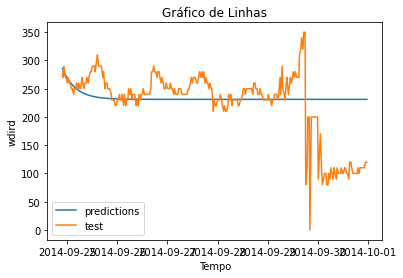

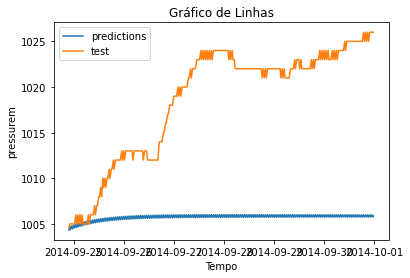

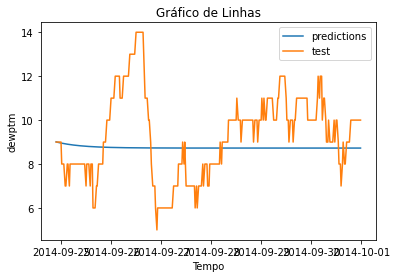

In [49]:
testing_plt('hum', auto_model_hum_fit)
testing_plt('tempm', auto_model_tempm_fit)
testing_plt('wspdm', auto_model_wspdm_fit)
testing_plt('wdird', auto_model_wdird_fit)
testing_plt('pressurem', auto_model_pressurem_fit)
testing_plt('dewptm', auto_model_dewptm_fit)

#### Using GridSearchCV

In [58]:
def best_model(col):
    # Define os valores dos parâmetros para teste
    p_values = range(0, 7)
    d_values = range(0, 7)
    q_values = range(0, 7)

    # Cria todas as combinações de parâmetros
    parameters = list(itertools.product(p_values, d_values, q_values))

    # Inicializa as variáveis para armazenar o melhor modelo e o menor AIC
    best_model = None
    best_aic = np.inf

    # Loop para ajustar e comparar os modelos
    for params in parameters:
        try:
            model = ARIMA(df_train[col], order=params)
            model_fit = model.fit()
            aic = model_fit.aic

            if aic < best_aic:
                best_model = model_fit
                best_aic = aic
        except:
            continue

    # Melhor modelo encontrado
    print("\n\nMelhor modelo para %s:" % col)
    print(best_model.summary())


In [59]:
for col in df_merged.columns:
    best_model(col)



Melhor modelo para hum:
                               SARIMAX Results                                
Dep. Variable:                    hum   No. Observations:                 3953
Model:                 ARIMA(3, 5, 3)   Log Likelihood                  -6.721
Date:                Sun, 21 May 2023   AIC                             27.442
Time:                        23:04:28   BIC                             71.409
Sample:                    08-01-2014   HQIC                            43.037
                         - 09-24-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   3.38e-07  -2.96e+06      0.000      -1.000      -1.000
ar.L2          1.0000   4.02e-08   2.49e+07      0.000       1.000       1.000
ar.L3          1.0000   4.



Melhor modelo para pressurem:
                               SARIMAX Results                                
Dep. Variable:              pressurem   No. Observations:                 3953
Model:                 ARIMA(3, 4, 3)   Log Likelihood                   0.000
Date:                Mon, 22 May 2023   AIC                             14.000
Time:                        00:52:25   BIC                             57.969
Sample:                    08-01-2014   HQIC                            29.596
                         - 09-24-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   4.21e-08  -2.38e+07      0.000      -1.000      -1.000
ar.L2          1.0000   9.02e-08   1.11e+07      0.000       1.000       1.000
ar.L3          1.000

### Results
The results are the following:
* hum: ARIMA(3, 5, 3)
* tempm: ARIMA(0, 6, 5)
* wspdm: ARIMA(2, 3, 6) 
* wdird: ARIMA(2, 4, 3)
* pressurem: ARIMA(3, 4, 3)
* dewptm: ARIMA(1, 6, 5)

### Fiting the models for best results

In [65]:
df_train.isnull().any().any()

False

In [68]:
best_model_hum = ARIMA(df_train['hum'], order=(3,5,3))
best_model_hum_fit = best_model_hum.fit()

best_model_tempm = ARIMA(df_train['tempm'], order=(0,6,5))
best_model_tempm_fit = best_model_tempm.fit()

best_model_wspdm = ARIMA(df_train['wspdm'], order=(2,3,6))
best_model_wspdm_fit = best_model_wspdm.fit()

best_model_wdird = ARIMA(df_train['wdird'], order=(2,4,3))
best_model_wdird_fit = best_model_wdird.fit()

best_model_pressurem = ARIMA(df_train['pressurem'], order=(3,4,3))
best_model_pressurem_fit = best_model_pressurem.fit()

best_model_dewptm = ARIMA(df_train['dewptm'], order=(1,6,5))
best_model_dewptm_fit = best_model_dewptm.fit()

### Forecasts

In [61]:
def forecasts(best_model_fit, num_periods):
    # Make predictions with confidence intervals
    forecast, stderr, conf_int = best_model_fit.forecast(steps=num_periods, alpha=0.05)

    # View predictions and confidence interval
    print("Forecasts:")
    print(np.round(forecast, 1))
    print("Confidence interval:")
    print( np.round(conf_int, 1))
    print("\n")

In [62]:
# Forecasts for 1h
forecasts(best_model_hum_fit, 3)
forecasts(best_model_tempm_fit, 3)
forecasts(best_model_wspdm_fit, 3)
forecasts(best_model_wdird_fit, 3)
forecasts(best_model_pressurem_fit, 3)
forecasts(best_model_dewptm_fit, 3)

Forecasts:
-9.487969635053936e+16
Confidence interval:
-9.512204021974949e+16


Forecasts:
-81616351610.9
Confidence interval:
-81831617156.1


Forecasts:
-169766119.7
Confidence interval:
-170024007.5


Forecasts:
-89836477304146.5
Confidence interval:
-90018495115090.7


Forecasts:
0.0
Confidence interval:
0.0


Forecasts:
86392840809.2
Confidence interval:
86639098774.0




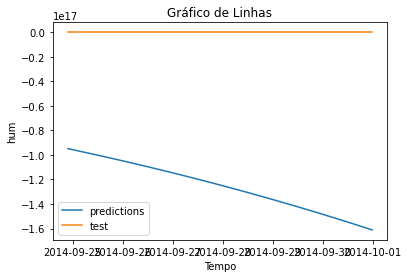

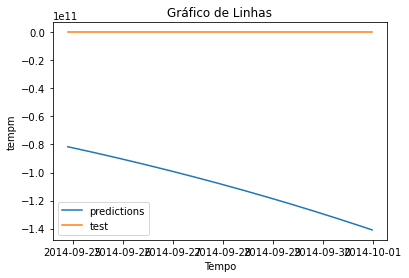

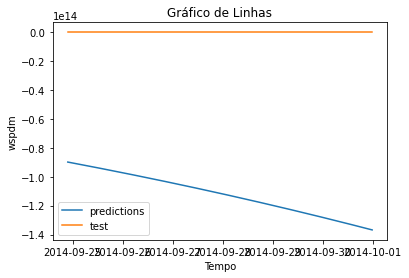

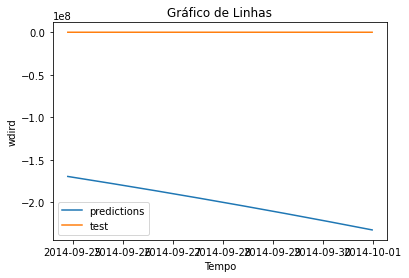

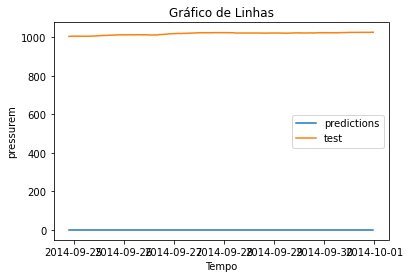

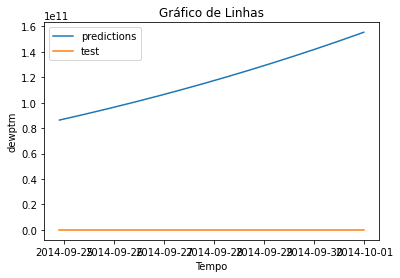

In [80]:
# predictions(best_model_hum_fit, 3)
# predictions(best_model_tempm_fit, 3)
# predictions(best_model_wdird_fit, 3)
# predictions(best_model_wspdm_fit, 3)
# predictions(best_model_pressurem_fit, 3)
# predictions(best_model_dewptm_fit, 3)

testing_plt('hum', best_model_hum_fit)
testing_plt('tempm', best_model_tempm_fit)
testing_plt('wspdm', best_model_wdird_fit)
testing_plt('wdird', best_model_wspdm_fit)
testing_plt('pressurem', best_model_pressurem_fit)
testing_plt('dewptm', best_model_dewptm_fit)

### Results

#### AutoARIMA
O melhor parâmetrofoi produzido pelo AutoARIMA

* hum:  ARIMA(5,1,2)(0,0,0)[0]          
* tempm:  ARIMA(1,1,3)(0,0,0)[0]          
* wspdm:  ARIMA(0,1,2)(0,0,0)[0]          
* wdird:  ARIMA(4,1,4)(0,0,0)[0] 
* pressurem:  ARIMA(4,1,5)(0,0,0)[0]          
* dewptm:  ARIMA(2,1,2)(0,0,0)[0] 